In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
import sys
sys.path.append('../')

In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import vgg16_bn
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from data.load import get_patched_data, get_patched_src, subsample
from data.utils import custom_cutout
from model.metrics import psnr, ssim

## Choose Devices

In [6]:
gpu_id = 3
num_cores = 4

In [7]:
torch.cuda.set_device(gpu_id)

## Set Experiment Name

In [29]:
nb_name = 'critic_patches_vgg_pretrained'

## Load Data

In [11]:
bs = 8  # batch size
size = 256  # image size
data_pth = Path('/home/alaa/Dropbox/BPHO Staff/USF')  # path to dataset
lr_dir = f'EM/training/trainsets/lr/'  # input images
hr_dir = f'EM/training/trainsets/hr/'  # target images
model_pth = data_pth/f'EM/models/critics'  # path to saved models
print(data_pth)  # confirm data path
print(model_pth) # confirm model path

/home/alaa/Dropbox/BPHO Staff/USF
/home/alaa/Dropbox/BPHO Staff/USF/EM/models/critics


In [12]:
random_patch = partial(custom_cutout, min_n_holes=10, max_n_holes=20,
                       min_length=15, max_length=25, use_on_y=False)

In [13]:
tfms = [[random_patch()], [random_patch()]]

In [14]:
tfms

[[RandTransform(tfm=TfmPixel (custom_cutout), kwargs={'min_n_holes': 10, 'max_n_holes': 20, 'min_length': 15, 'max_length': 25}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=False)],
 [RandTransform(tfm=TfmPixel (custom_cutout), kwargs={'min_n_holes': 10, 'max_n_holes': 20, 'min_length': 15, 'max_length': 25}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=False)]]

In [15]:
# Create databunch
data = get_patched_data(data_pth, hr_dir, bs, tfms=tfms,
                        in_sz=size, out_sz=size)

In [16]:
# Dataset sizes
len(data.train_ds), len(data.valid_ds)

(79998, 19999)

In [17]:
# Batch size and number of batches
data.batch_size, len(data.train_dl)

(8, 9999)

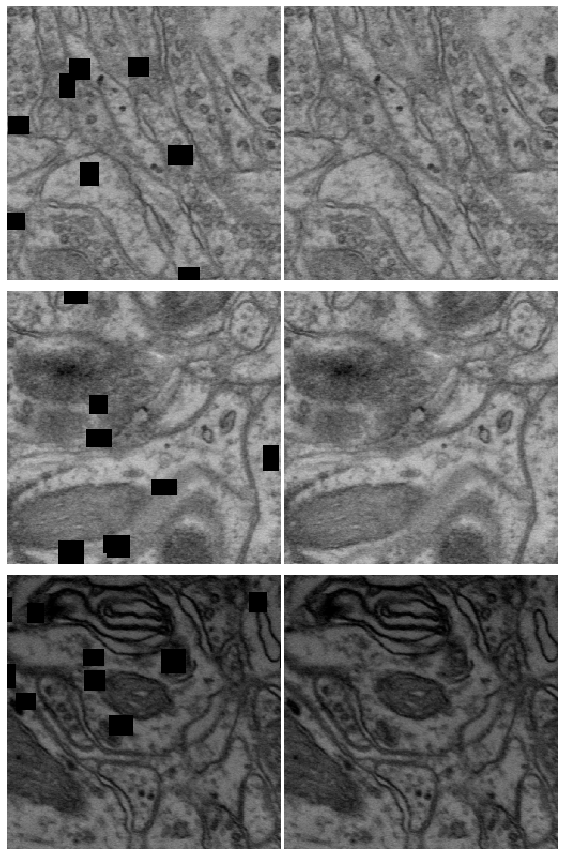

In [18]:
# Data Visualization
data.show_batch(rows=3)

## Data Subsample

In [19]:
data = subsample(data)

In [20]:
data.c

3

In [21]:
# Dataset sizes
len(data.train_dl), len(data.valid_dl)

(999, 250)

In [22]:
# Batch size and number of batches
data.batch_size

8

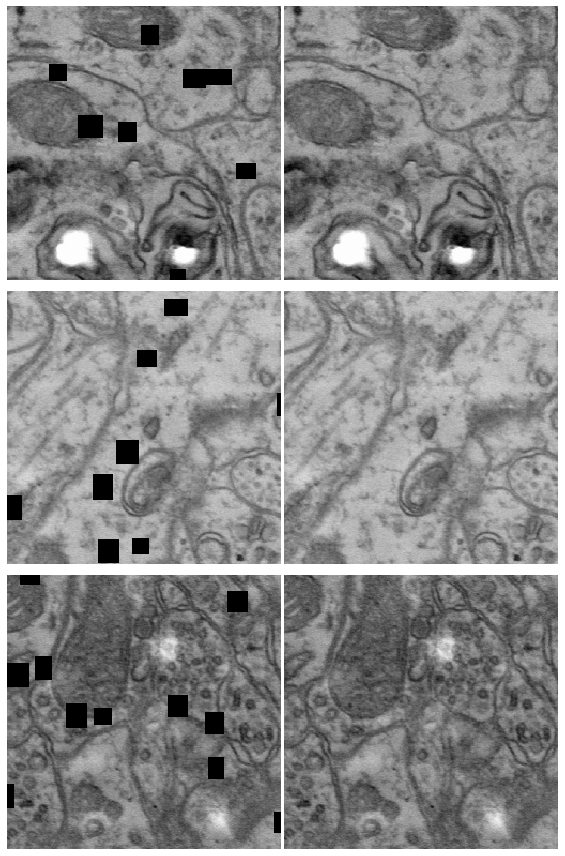

In [23]:
# Data Visualization
data.show_batch(rows=3)

# Model

## Initialization

In [25]:
arch = vgg16_bn
wd = 1e-3
metrics = [F.mse_loss, psnr, ssim]
learn = unet_learner(data, arch, wd=wd, 
                         #loss_func=feat_loss,
                         loss_func=F.mse_loss,
                         metrics=metrics, 
                         #callback_fns=LossMetrics, 
                         blur=False, 
                         norm_type=NormType.Weight, 
                         model_dir=model_pth)
gc.collect()

25539

In [26]:
learn.model_dir = model_pth
print(learn.model_dir)

/home/alaa/Dropbox/BPHO Staff/USF/EM/models/critics


## Load Model (optional)

In [22]:
# did not load any model

## Training

In [27]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


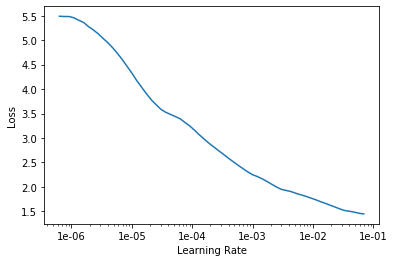

In [28]:
learn.recorder.plot()

### 1a

In [30]:
lr = 5e-4
learn.fit_one_cycle(1, max_lr=lr)
learn.save(f'{nb_name}.1a', with_opt=False)

epoch,train_loss,valid_loss,mse_loss,psnr,ssim,time
0,0.013143,0.014014,0.014014,27.333946,0.940809,12:37


In [31]:
learn.validate()

[0.014088806, tensor(0.0141), tensor(27.3684), tensor(0.9408)]

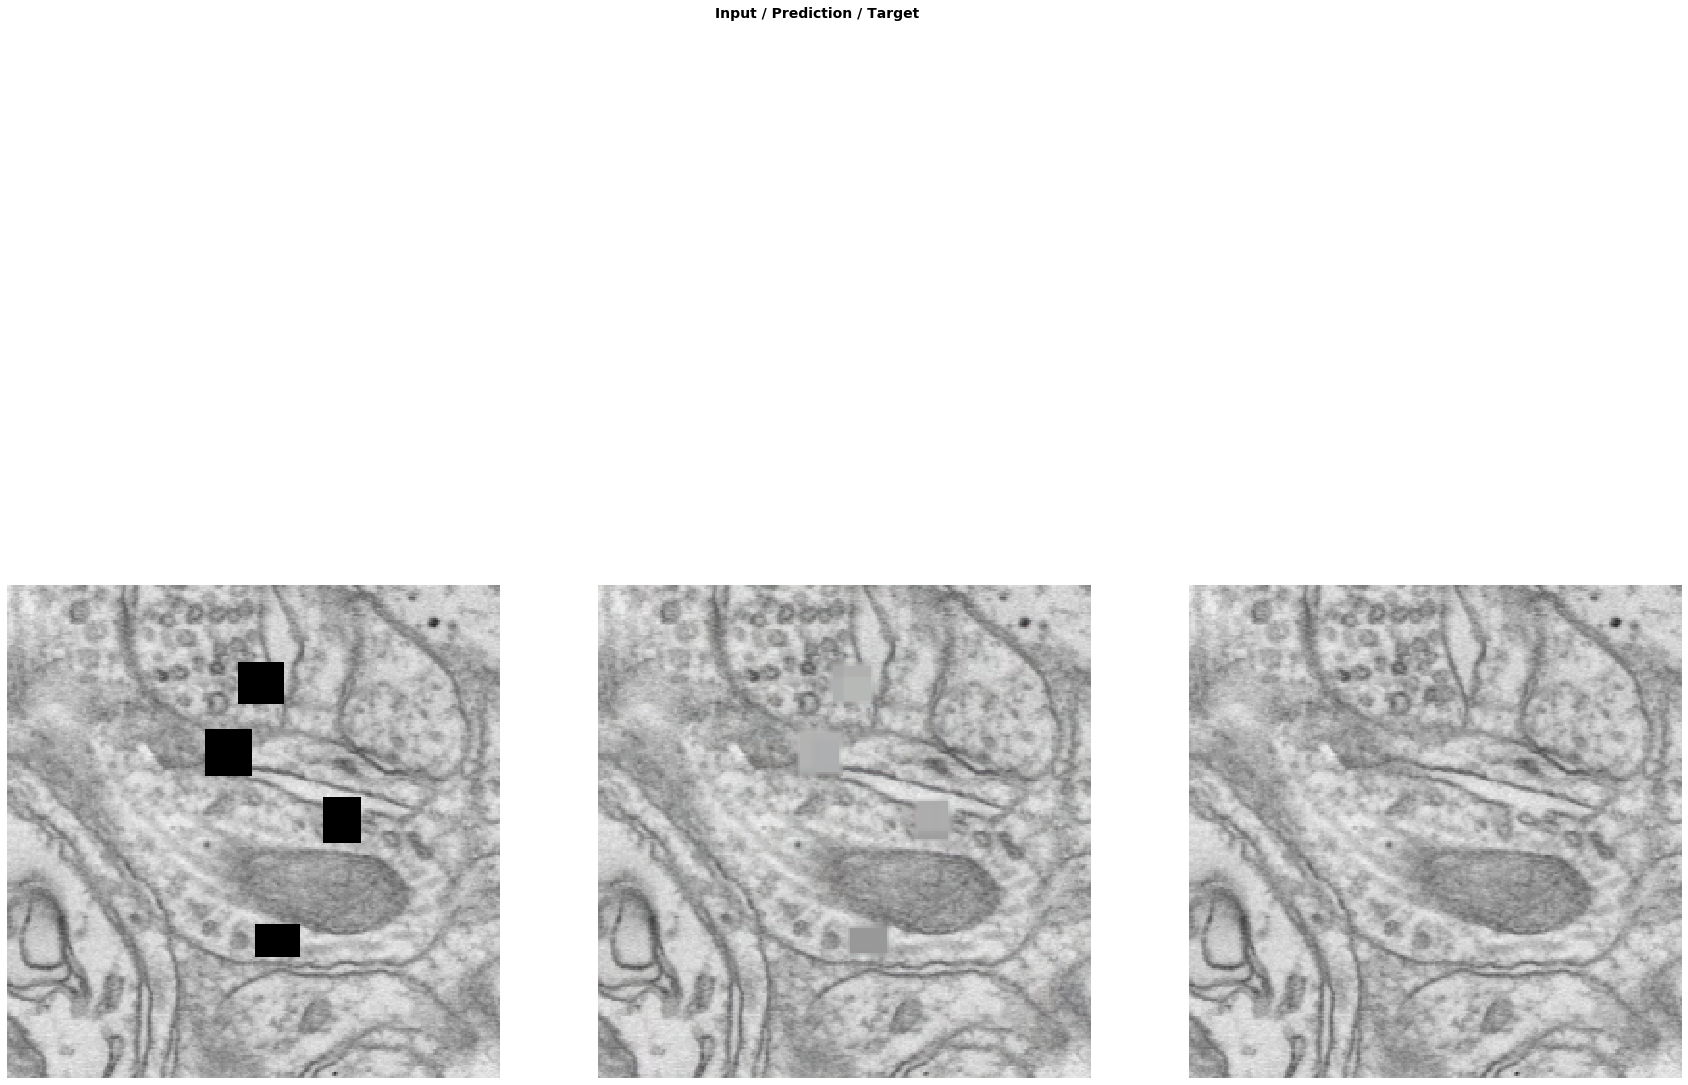

In [32]:
learn.show_results(rows=1, figsize=(30,24))

### 1b

In [33]:
learn.unfreeze()

In [34]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


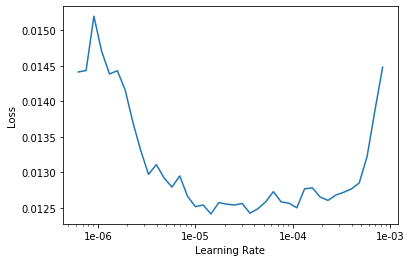

In [35]:
learn.recorder.plot()

In [36]:
lr = slice(1e-5, 1e-4)
learn.fit_one_cycle(3, max_lr=lr)
learn.save(f'{nb_name}.1b', with_opt=False)

epoch,train_loss,valid_loss,mse_loss,psnr,ssim,time
0,0.010942,0.009843,0.009843,28.374258,0.949825,13:08
1,0.008827,0.008067,0.008067,29.199825,0.952582,13:11
2,0.007986,0.007955,0.007955,29.283255,0.954651,13:11


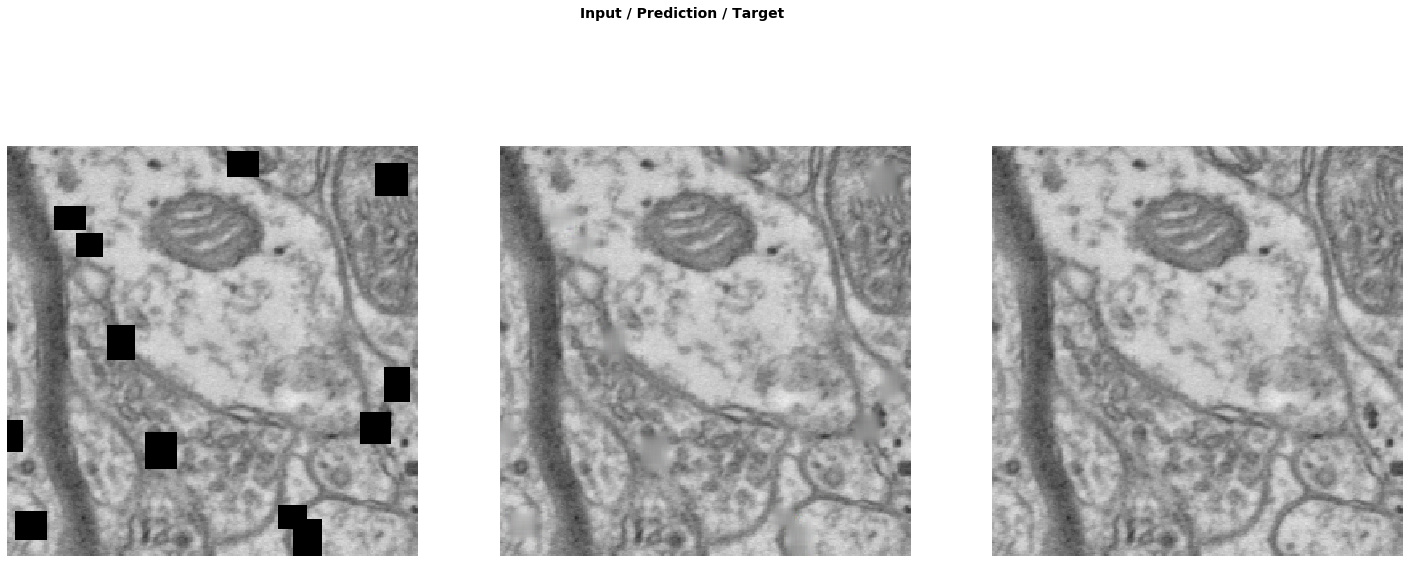

In [39]:
learn.show_results(rows=1, figsize=(25, 10))

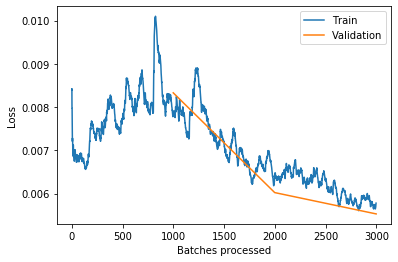

In [40]:
learn.recorder.plot_losses()